In [1]:
import os, json

# set ads dict: HPEESOF_DIR and home director : HOME
os.environ['HPEESOF_DIR'] = 'D:/ADS/install'
os.environ['HOME'] = 'D:/ADS/dir'

from keysight.ads import de
from keysight.ads.de import db_uu as db
from keysight.edatoolbox import ads
import keysight.ads.dataset as dataset
from keysight.edatoolbox import util
from pathlib import Path
from IPython.core import getipython

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
class PyADS():
    def __init__(self):
        self.HPEESOF_DIR = 'D:/ADS/install'
        self.HOME = 'D:/ADS/dir'
        self.cur_workspace_path = None
        self.workspace = None
        self.cur_library_name = None
        self.library = None
        self.cur_design_name = None
        self.design = None

    def create_and_open_an_empty_workspace(self, workspace_path: str):
    # example : workspace_path = "C:/ADS_Python_Tutorials/tutorial1_wrk"
    # Ensure there isn't already a workspace open
        if de.workspace_is_open():
            de.close_workspace()
    
        # Cannot create a workspace if the directory already exists
        if os.path.exists(workspace_path):
            raise RuntimeError(f"Workspace directory already exists: {workspace_path}")
    
        # Create the workspace
        workspace = de.create_workspace(workspace_path)
        # Open the workspace
        workspace.open()
        # Return the open workspace and close when it finished
        return workspace
    
    def create_a_library_and_add_it_to_the_workspace(self, workspace: de.Workspace, library_name: str) -> None:
        #assert workspace.path is not None
        # Libraries can only be added to an open workspace
        assert workspace.is_open
        # We'll create a library in the directory of the workspace
        library_path = workspace.path / library_name
        # Create the library
        de.create_new_library(library_name, library_path)
        # And add it to the workspace (update lib.defs)
        workspace.add_library(library_name, library_path, de.LibraryMode.SHARED)
        lib=workspace.open_library(library_name,library_path,de.LibraryMode.SHARED)
        return lib

    def schematic_simulation(self, workspace_path: str, library_name: str, design_name: str, instance_name: str, var_dict: dict, vgs_bias_param_sweep_name: str, vds_bias_param_sweep_name: str, vgs_bias_simulation_name: str, vds_bias_simulation_name: str) -> None:
        ''' Load Path and files, Edit the design variables, Simulate the design, and return the dataset '''

        # >> Load Path and files
        if not os.path.exists(workspace_path):
            raise RuntimeError(f"Workspace directory doesn't exist: {workspace_path}")
        if de.workspace_is_open():
            de.close_workspace()
        
        # Open the workspace
        # if (not self.workspace) or (self.cur_workspace_path != workspace_path):
        self.workspace = de.open_workspace(workspace_path)
        self.cur_workspace_path = workspace_path
        # Open the library
        # if (not self.library) or (self.cur_library_name != library_name):
        self.library = self.workspace.open_library(lib_name=library_name, mode=de.LibraryMode.SHARED)
        self.cur_library_name = library_name
        # Open the design
        # if (not self.design) or (self.cur_design_name != design_name):
        self.design = db.open_design((library_name, design_name, "schematic"), db.DesignMode.APPEND)
        self.cur_design_name = design_name

        # >> Edit the design variables
        # edit VAR
        v = self.design.get_instance(inst_name=instance_name)
        assert v.is_var_instance
        for var_name in var_dict:
            v.vars[var_name] = var_dict[var_name]
        # Save the design
        self.design.save_design()
        # Simulate the design
        output_dir = os.path.join(self.workspace.path, "output")
        # create the simulation output directory
        util.safe_makedirs(output_dir)


        # >> Simulate and return the dataset
        ipython = getipython.get_ipython()
        if ipython is None:
            print("The remaining portion of the script must be run in an IPython environment. Exiting.")
            return
        # capture the netlist in a string
        netlist = self.design.generate_netlist()
        # access to the simulator object to run netlists
        simulator = ads.CircuitSimulator()
        # run the netlist, this will block output
        simulator.run_netlist(netlist, output_dir=output_dir)
        output_data = dataset.open(Path(os.path.join(output_dir, f"{design_name}.ds")))
        
        # >> return data in pandas DataFrame format
        # <class 'pandas.core.frame.DataFrame'>
        data_ids_vds = output_data[f'{vgs_bias_param_sweep_name}.{vgs_bias_simulation_name}.DC'].to_dataframe().reset_index()
        data_ids_vgs = output_data[f'aele_0.{vds_bias_param_sweep_name}.{vds_bias_simulation_name}'].to_dataframe().reset_index()
        return data_ids_vds, data_ids_vgs
    


    def dataset_reshape(self, pd_data_IV: pd.DataFrame, pd_data_gm: pd.DataFrame, IV_dimension: list, gm_dimension: list, var_dict: dict):
        ''' reshape the dataset into desired input matrix and output vector '''
        IV_row_count = IV_dimension[0] # Vgs
        IV_col_count = IV_dimension[1] # Vds
        gm_row_count = gm_dimension[0] # Vds
        gm_col_count = gm_dimension[1] # Vgs

        output_x_IV = np.empty((IV_row_count, IV_col_count),dtype=np.float64)
        output_x_gm = np.empty((gm_row_count, gm_col_count),dtype=np.float64)
        output_y = np.empty((len(var_dict), 1),dtype=np.float64)

        for row in range(IV_row_count):
            output_x_IV[row, :] = pd_data_IV.loc[pd_data_IV['VGS'] == (row + 1), 'IDS.i'].to_numpy()
        for col in range(gm_col_count):
            output_x_gm[:, col] = pd_data_gm.loc[pd_data_gm['VGS'] == (col + 1.5), 'gm'].to_numpy()
        for index, item in enumerate(var_dict):
            output_y[index, 0] = var_dict[item]

        return output_x_IV, output_x_gm, output_y
    

def param_random_generator():
    ''' generate a random parameter set for the HEMT model '''
    # define the parameter range
    param_range = {
        'VOFF': (1, 3.5),
        'U0': (150e-3, 800e-3),
        'NS0ACCS': (5e15, 5e20),
        'NFACTOR': (0.2, 1),
        'ETA0': (0, 1),
        'VSAT': (50e3, 250e3),
        'VDSCALE': (0, 10),
        'CDSCD': (0, 5),
        'LAMBDA': (100e-6, 0.5),
        'MEXPACCS': (1, 5)
    }
    
    # generate random parameters
    var_dict = {key: str(np.random.uniform(low=val[0], high=val[1])) for key, val in param_range.items()}
    
    return var_dict

    


In [3]:
workspace_path = "E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Simulation\\ADS\\ASM_HEMT1_wrk_1_Jia"
library_name = "IAF_pGaN_lib"
design_name = "gs66508bv1_Pytest_simple_paramset"
instance_name = "IV"
var_dict = {'VOFF':'1.785', 'U0':'0.424', 'NS0ACCS':'2e+17', 'NFACTOR':'1', 'ETA0':'0.06', 'VSAT':'8e+4', 'VDSCALE':'5', 'CDSCD':'0.1', 'LAMBDA':'0.01', 'MEXPACCS':'1.5'}
vgs_bias_param_sweep_name = 'Sweep_vgs'
vds_bias_param_sweep_name = 'Sweep_vds'
vgs_bias_simulation_name = 'DC1'
vds_bias_simulation_name = 'DC2'

In [4]:
ads_ctrl = PyADS()
  

In [5]:
start_time = time.time()
var_dict = param_random_generator()
pd_data_vgs_bias, pd_data_gm = ads_ctrl.schematic_simulation(
    workspace_path,
    library_name,
    design_name,
    instance_name,
    var_dict,
    vgs_bias_param_sweep_name,
    vds_bias_param_sweep_name,
    vgs_bias_simulation_name,
    vds_bias_simulation_name
)
X_iv, X_gm, y = ads_ctrl.dataset_reshape(pd_data_vgs_bias, pd_data_gm, [7, 236], [236, 6], var_dict)
end_time = time.time()

print(' >> used time:', round(end_time - start_time, 2), 'seconds')

 >> used time: 72.92 seconds


In [10]:
print(pd_data_gm)
print(X_gm[0,:])


       VDS  VGS         gm
0     -3.5  1.5 -39.728921
1     -3.5  2.5 -40.526411
2     -3.5  3.5 -41.064988
3     -3.5  4.5 -41.473551
4     -3.5  5.5 -41.810955
...    ...  ...        ...
1411  20.0  2.5  48.787684
1412  20.0  3.5  50.987816
1413  20.0  4.5  52.574400
1414  20.0  5.5  53.982311
1415  20.0  6.5  55.129456

[1416 rows x 3 columns]
[-39.72892097 -40.52641091 -41.06498753 -41.47355103 -41.81095496
 -42.10489373]


In [8]:
output_data = dataset.open(Path("E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Simulation\\ADS\\ASM_HEMT1_wrk_1_Jia\\output\\gs66508bv1_Pytest_simple_paramset.ds"))

In [10]:
print(output_data.varblock_names)
print(output_data['aele_0.Sweep_vds.DC2'].to_dataframe().reset_index())

['Sweep_vds.DC2.DC', 'Sweep_vgs.DC1.DC', 'aele_0.Sweep_vds.DC2']
     VDS  VGS           gm
0   -3.5  1.5   -74.933659
1   -3.5  2.5   -76.539316
2   -3.5  3.5   -77.811422
3   -3.5  4.5   -78.828257
4   -3.5  5.5   -79.652375
5   -3.5  6.5   -80.330435
6    1.5  1.5    31.535762
7    1.5  2.5    41.288172
8    1.5  3.5    45.129297
9    1.5  4.5    47.162106
10   1.5  5.5    48.392277
11   1.5  6.5    49.207899
12   6.5  1.5   149.625741
13   6.5  2.5   101.084242
14   6.5  3.5   114.157551
15   6.5  4.5   114.137883
16   6.5  5.5   115.154412
17   6.5  6.5   116.579209
18  11.5  1.5   488.646030
19  11.5  2.5    72.601509
20  11.5  3.5   152.399710
21  11.5  4.5   184.268213
22  11.5  5.5   184.604465
23  11.5  6.5   183.705134
24  16.5  1.5  1041.551248
25  16.5  2.5   111.209663
26  16.5  3.5    73.483493
27  16.5  4.5   209.771640
28  16.5  5.5   250.065193
29  16.5  6.5   254.096808
30  20.0  1.5  1512.993847
31  20.0  2.5   234.822582
32  20.0  3.5    -4.082334
33  20.0  4.5   1

In [14]:
print("Input Matrix (X):", X)
print("Output Vector (y):", y)
print('shape of X is: ',X.shape)
print("type of X is ", type(X))
print('shape of Y is: ',y.shape)
print("type of Y is ", type(y))

Input Matrix (X): [[-166.7571349  -158.85504971 -151.03125075 ...   10.57345608
    10.64958201   10.72710807]
 [-230.75172121 -222.39994404 -214.10743697 ...  278.3166511
   280.38471414  282.45884474]
 [-296.9645886  -288.25713541 -279.59750528 ...  557.10455266
   561.70219799  566.31139883]
 ...
 [-433.71787232 -424.42365429 -415.16151659 ...  599.98518177
   603.37666404  606.78537481]
 [-503.57294333 -494.01319855 -484.47869614 ...  686.20982955
   689.49938788  692.79902552]
 [-574.13185779 -564.31466814 -554.51601359 ...  778.15337345
   781.57423838  785.00321867]]
Output Vector (y): [[1.87616982e+00]
 [5.60270093e-01]
 [1.99321982e+20]
 [7.81410538e-01]
 [8.41053295e-01]
 [1.60736141e+05]
 [1.76239716e-01]
 [3.44605719e+00]
 [2.33602326e-02]
 [2.58153480e+00]]
shape of X is:  (7, 236)
type of X is  <class 'numpy.ndarray'>
shape of Y is:  (10, 1)
type of Y is  <class 'numpy.ndarray'>


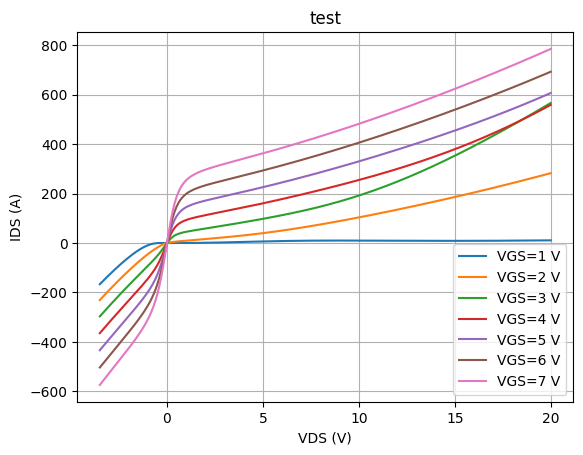

In [16]:
# switch to a dataframe representation
# reset the index to normalize the data

_, ax = plt.subplots()
ax.set_title("test")  # type: ignore
for i in range(1, 8):
    plt.plot(np.arange(-3.5,20.1,0.1), X[i-1,:], label=f"VGS={i} V")
plt.xlabel("VDS (V)")
plt.ylabel("IDS (A)")
plt.legend()
plt.grid()


In [ ]:
from joblib import Parallel, delayed

def test(a, b, c):
    return [a, b, c]

params = [(1,2,3)]

# n_jobs=4 相当于 4 个“进程池 worker”
out = Parallel(n_jobs=4, backend="loky")(delayed(test)(*p) for p in params)
print(out)

[[1, 2, 3]]


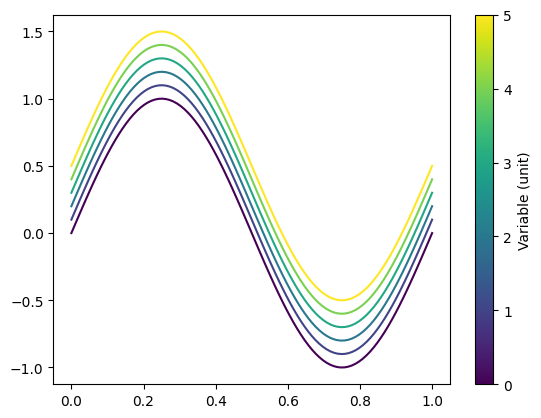

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 模拟数据
x = np.linspace(0, 1, 100)
y_base = np.sin(2 * np.pi * x)
legend_values = np.linspace(0, 5, 6)  # 6 个不同的变量值

# 创建 colormap
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=legend_values.min(), vmax=legend_values.max())

fig, ax = plt.subplots()

for val in legend_values:
    color = cmap(norm(val))
    ax.plot(x, y_base + val * 0.1, color=color)

# 加颜色条
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # 仅用于colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Variable (unit)")

plt.show()


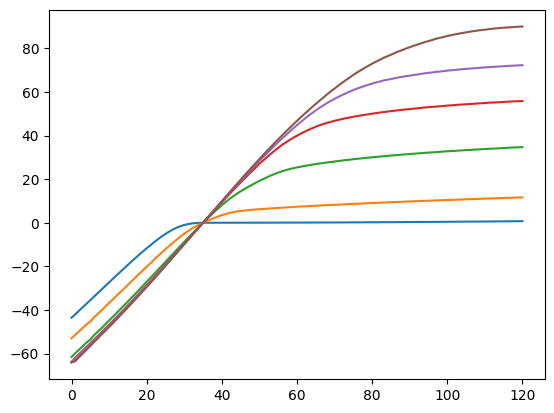

In [1]:
import h5py
import matplotlib.pyplot as plt

path = 'E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting_local/IV_param_regression/data_pre_processing/data/meas_file_reshape.h5'

with h5py.File(path, 'r') as f:
    x_iv = f['X'][0,:,:] 
    for i in range(x_iv.shape[0]):
        plt.plot(x_iv[i, :])
